# Modelling

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

from utils.classification_helpers import combine_orbit_predictions
from utils.validation_helpers import evaluate_with_3x3_window

In [ ]:
# Load final dataset
final_df = pd.read_csv('../data/processed/final/final_data.csv')
final_df_stable = pd.read_csv('../data/processed/final/final_data_stable.csv')

# Remove rows where ref_min is -70
#final_df = final_df[final_df['ref_VV_min'] != -70]
#final_df_stable = final_df_stable[final_df_stable['ref_VV_min'] != -70]

In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

In [8]:
# 1. Check feature distribution and handle missing values
print(f"Feature dataset shape: {final_df_stable.shape}")
print(f"Missing values: {final_df_stable.isnull().sum().sum()}")

# Fill missing values with median
final_df_stable = final_df_stable.fillna(final_df_stable.median())

Feature dataset shape: (8448, 125)
Missing values: 8886


In [9]:
# 2. Prepare features and target
X = final_df_stable.drop(['point_id', 'point_lon', 'point_lat', 'is_damaged'], axis=1)
y = final_df_stable['is_damaged']

In [11]:
# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in testing: {np.bincount(y_test)}")

Training set: 5913 samples
Testing set: 2535 samples
Class distribution in training: [2956 2957]
Class distribution in testing: [1268 1267]


/var/folders/r4/hzh5vjhs64sfqz3fgg0md4x80000gn/T/ipykernel_18822/3015154918.py:8: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print(f"Class distribution in training: {np.bincount(y_train)}")
/var/folders/r4/hzh5vjhs64sfqz3fgg0md4x80000gn/T/ipykernel_18822/3015154918.py:9: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print(f"Class distribution in testing: {np.bincount(y_test)}")


In [14]:
# 4. Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 5. Define hyperparameters for random search
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [27]:
# 6. Perform cross-validation and grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_grid, 
    n_iter=20,  # Sample combinations
    cv=cv, 
    scoring='f1', 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [None, 10, 20],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 200]},
                   random_state=42, scoring='f1', verbose=1)

In [28]:
# 7. Print best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

Best parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 20}
Best cross-validation score: 0.6741


In [29]:
# 8. Evaluate the model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]


Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.71      0.69      1268
         1.0       0.69      0.64      0.66      1267

    accuracy                           0.67      2535
   macro avg       0.68      0.67      0.67      2535
weighted avg       0.68      0.67      0.67      2535



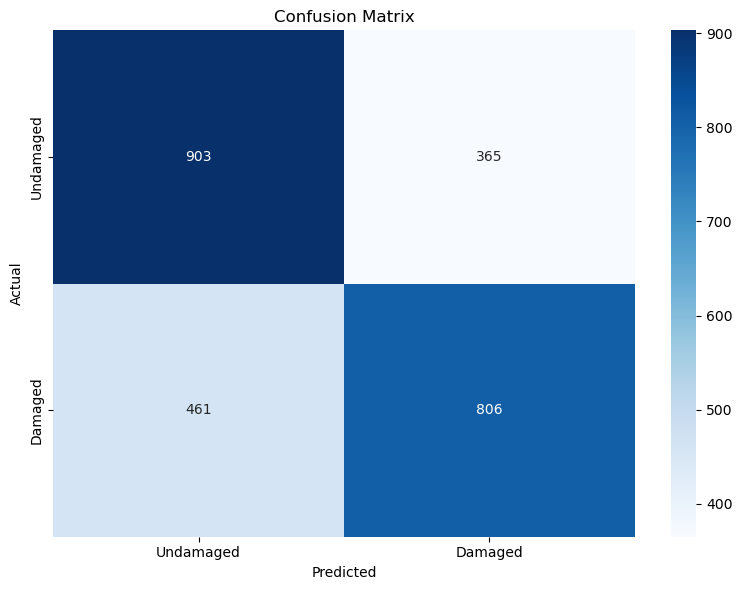

In [30]:
# 9. Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 10. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Undamaged', 'Damaged'],
            yticklabels=['Undamaged', 'Damaged'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

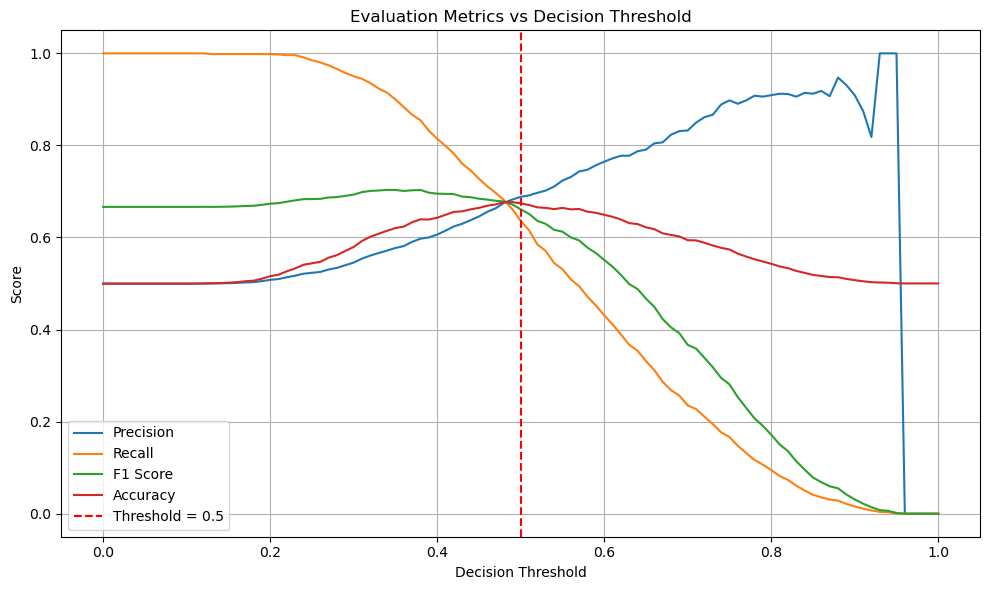

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define thresholds to evaluate
thresholds = np.linspace(0, 1, 101)

# Store metrics
precisions = []
recalls = []
f1s = []
accuracies = []

# Calculate metrics for each threshold
for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))
    accuracies.append(accuracy_score(y_test, y_pred_thresh))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.plot(thresholds, accuracies, label='Accuracy')
# Add vertical line 0.5 threshold
plt.axvline(x=0.5, color='r', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs Decision Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()